# 480 gages pre-trained LSTM model

### 7/16/2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os, math, keras, random
from keras import layers, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import SimpleExpSmoothing
from keras.callbacks import EarlyStopping
from datetime import datetime
import hydroeval as he
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
proj_dir = os.getcwd()
os.chdir(proj_dir)

### Read in site data

In [4]:
OC2 = pd.read_csv(proj_dir + r"/data/OC2.csv", index_col=[0])
OC2.index = pd.to_datetime(OC2.index).date
LF1 = pd.read_csv(proj_dir + r"/data/LF1.csv", index_col=[0])
LF1.index = pd.to_datetime(LF1.index).date
LF2 = pd.read_csv(proj_dir + r"/data/LF2.csv", index_col=[0])
LF2.index = pd.to_datetime(LF2.index).date
OC4 = pd.read_csv(proj_dir + r"/data/OC4.csv", index_col=[0])
OC4.index = pd.to_datetime(OC4.index).date
LF3 = pd.read_csv(proj_dir + r"/data/LF3.csv", index_col=[0])
LF3.index = pd.to_datetime(LF3.index).date
OC1 = pd.read_csv(proj_dir + r"/data/OC1.csv", index_col=[0])
OC1.index = pd.to_datetime(OC1.index).date
OC3 = pd.read_csv(proj_dir + r"/data/OC3.csv", index_col=[0])
OC3.index = pd.to_datetime(OC3.index).date

### Create dataframes with no missing DO values

In [5]:
OC2_noNA = OC2.dropna(subset=['o'])
LF1_noNA = LF1.dropna(subset=['o'])
LF2_noNA = LF2.dropna(subset=['o'])
OC4_noNA = OC4.dropna(subset=['o'])
LF3_noNA = LF3.dropna(subset=['o'])
OC1_noNA = OC1.dropna(subset=['o'])
OC3_noNA = OC3.dropna(subset=['o'])

### Create list of all site data

In [6]:
site_dfs_noNA = [OC2_noNA, LF1_noNA, LF2_noNA, OC4_noNA, LF3_noNA, OC1_noNA, OC3_noNA]

### Read in data, drop unnecessary variables, scale data, and split into X and y

In [7]:
data = pd.read_csv(proj_dir + r"/data/river_training_data.csv", index_col=[0])
data.index = pd.to_datetime(data.index).date
data.head()

,temp,q,o,lat,lon,STAID,BFI,PET,CONTACT,EWT,...,NORM_STORAGE2013,MAJOR2013,HDENS10,dayl (s),prcp (mm/day),srad (W/m2),swe (kg/m2),tmax (degrees C),tmin (degrees C),vp (Pa)
2014-05-02,7.6,73.8,10.0,39.104997,-111.228992,9326500,61.81,457.51,64.31,-47.98,...,2083.0,0.0,0.05,49339.691406,0.0,534.349976,0.0,18.030001,1.40,567.789978
2014-05-03,7.9,106.0,9.9,39.104997,-111.228992,9326500,61.81,457.51,64.31,-47.98,...,2083.0,0.0,0.05,49471.230469,0.0,525.289978,0.0,20.920000,4.51,694.919983
2014-05-04,7.6,150.0,9.9,39.104997,-111.228992,9326500,61.81,457.51,64.31,-47.98,...,2083.0,0.0,0.05,49601.308594,0.0,443.140015,0.0,19.740000,7.51,929.309998
2014-05-05,6.6,203.0,10.2,39.104997,-111.228992,9326500,61.81,457.51,64.31,-47.98,...,2083.0,0.0,0.05,49729.878906,0.0,416.709991,0.0,18.020000,6.92,921.429993
2014-05-06,5.7,197.0,10.3,39.104997,-111.228992,9326500,61.81,457.51,64.31,-47.98,...,2083.0,0.0,0.05,49856.890625,0.0,424.690002,0.0,12.610000,1.53,651.440002


In [8]:
print(data.shape)

(2254385, 140)


In [9]:
data_noNA = data.dropna(subset=['o'])
print(data_noNA.shape)

(1558230, 140)


### Drop columns based on correlation analysis and random forest feature selection

In [10]:
with open(proj_dir + '/data/vars_to_keep_FS.txt', "r") as file:
    vars_to_keep = [line.strip() for line in file]
for i, df in enumerate(site_dfs_noNA):
    df = df[vars_to_keep]
    df = df.sort_index(axis=1)
    site_dfs_noNA[i] = df
data = data[vars_to_keep]
data_noNA = data_noNA[vars_to_keep]
master_noNA = pd.concat(site_dfs_noNA)

### Drop sites with less than one year of data

In [11]:
river_site_dfs = {}
data_noNA['site'] = data_noNA.groupby(['lat', 'lon']).ngroup()
sites = data_noNA['site'].unique()
for site in sites:
    temp_df = data_noNA[data_noNA['site'] == site]
    if len(temp_df) >= 365: # only keep sites with a year or more worth of data
        temp_df = temp_df.drop('site', axis=1)
        river_site_dfs[site] = temp_df
    else:
        data_noNA = data_noNA[data_noNA['site'] != site]
    river_site_dfs[site] = temp_df
    
data_noNA.drop('site', axis=1, inplace=True)

In [12]:
print(len(river_site_dfs))

480


### Reorder columns alphabetically so they are fed into the models in the same place

In [13]:
# Reorder columns alphabetically
master_noNA = master_noNA.sort_index(axis=1)
data_noNA = data_noNA.sort_index(axis=1)

# Check to make sure columns are in the same order
for i, col in enumerate(master_noNA.columns):
    print(col, " : ", list(data_noNA.columns)[i])

ARTIFICIAL  :  ARTIFICIAL
BASIN_AREA  :  BASIN_AREA
BEDPERM_6  :  BEDPERM_6
BFI  :  BFI
CNPY11_BUFF100  :  CNPY11_BUFF100
CONTACT  :  CONTACT
ELEV_MAX  :  ELEV_MAX
ELEV_MEAN  :  ELEV_MEAN
ELEV_MIN  :  ELEV_MIN
FUNGICIDE  :  FUNGICIDE
HGAD  :  HGAD
HGC  :  HGC
LAKEPOND  :  LAKEPOND
N97  :  N97
NLCD01_52  :  NLCD01_52
NLCD01_81  :  NLCD01_81
NLCD01_95  :  NLCD01_95
RH  :  RH
SALINAVE  :  SALINAVE
SANDAVE  :  SANDAVE
SILTAVE  :  SILTAVE
STRM_DENS  :  STRM_DENS
WDANN  :  WDANN
dayl (s)  :  dayl (s)
lat  :  lat
lon  :  lon
o  :  o
prcp (mm/day)  :  prcp (mm/day)
q  :  q
sinuosity  :  sinuosity
srad (W/m2)  :  srad (W/m2)
swe (kg/m2)  :  swe (kg/m2)
temp  :  temp
tmax (degrees C)  :  tmax (degrees C)
tmin (degrees C)  :  tmin (degrees C)
vp (Pa)  :  vp (Pa)


## Data preprocessing pipeline

## Scale data

In [14]:
# create a dataframe with USGS and site data for accurate scaling
all_data_df = pd.concat([master_noNA, data_noNA])
all_data_df = all_data_df.sort_index(axis=1)

# First fit scaler just to y data for rescaling predictions
scaler_y = MinMaxScaler()
scaler_y.fit(np.array(all_data_df["o"]).reshape(-1, 1))

# Scale dataset
scaler = MinMaxScaler()
scaler.fit(all_data_df.values)

MinMaxScaler()

In [15]:
from utils import preprocessing_functions as ppf
data_sc = ppf.data_pipeline(data, 1e-7, scaler)
data_sc_noNA = ppf.data_pipeline(data_noNA, 1e-7, scaler)

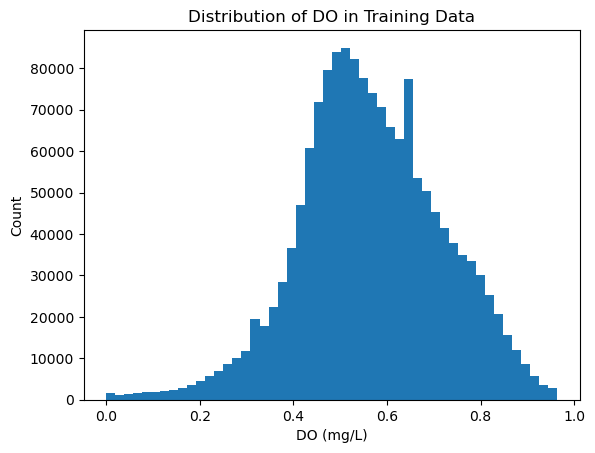

In [16]:
plt.hist(data_sc_noNA['o'], bins=50)
plt.title("Distribution of DO in Training Data")
plt.xlabel("DO (mg/L)")
plt.ylabel("Count")
plt.show()

### Scale site data

In [17]:
site_dfs_sc_noNA = []
for df in site_dfs_noNA:
    df_sc = ppf.data_pipeline(df, 1e-7, scaler)
    site_dfs_sc_noNA.append(df_sc)

### Testing

#### Hyperparameters

In [18]:
seed = 12
split_pct = 0.7
window_length = 10
hidden_layers = 1
hidden_units = 8
batch_size = 256
n_epochs = 150
activation_dense = 'relu'
learning_rate = 0.0008
dropout = 0.2
stop_patience = 15


In [19]:
data_sc_train, data_sc_test, riv_data_site_inds = ppf.train_test_split_evenSites(data_sc_noNA, split_pct)
X_train = data_sc_train.drop('o', axis=1)
y_train = data_sc_train['o']
X_test = data_sc_test.drop('o', axis=1)
y_test = data_sc_test['o']

In [20]:
# Get training and testing generators
train_gen = ppf.data_generator(X_train, y_train, window_length, batch_size)
test_gen = ppf.data_generator(X_test, y_test, window_length, batch_size)

# Calculate steps per epoch
steps_per_epoch = ppf.get_steps_per_epoch(X_train, window_length, batch_size)
val_steps = ppf.get_steps_per_epoch(X_test, window_length, batch_size)

960853
413169


In [21]:
print(steps_per_epoch)
print(val_steps)

3753
1613


In [ ]:
from utils import model_building_training_functions as mbf

# Build the model
keras.utils.set_random_seed(seed)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train.columns)
model = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
# Uncomment if model has already been trained
# model.load_weights(proj_dir + '/model_weights/River_LSTM.weights.h5')

In [48]:
keras.utils.set_random_seed(0)
earlyStopping = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0000001, verbose=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=proj_dir +'/model_weights/River_LSTM.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

callbacks = [earlyStopping, lr_scheduler, checkpoint_callback]
history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, batch_size=batch_size, 
                    epochs=n_epochs, verbose=1, validation_data=test_gen, 
                    validation_steps=val_steps, callbacks=callbacks)

In [ ]:
plt.figure(figsize=(6,4), dpi=400)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pretraining Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Test river LSTM on river data

In [ ]:
river_preds = model.predict(test_gen, steps=val_steps)
def extract_true_values(generator, steps):
    y_batches = []

    for step, (X_batch, y_batch) in enumerate(generator):
        if step >= steps:  # Stop after val_steps steps
            break
        y_batches.append(y_batch)

    # Combine all batches into a single array or tensor
    y_true = tf.concat(y_batches, axis=0)
    return y_true

y_true = extract_true_values(test_gen, val_steps)

In [ ]:
def evaluate_river_predictions(y_true, y_preds, scaler_y):
    # Convert to 1-D arrays and inverse tranform
    y_true -= 1e-7
    y_preds -= 1e-7
    
    actual = scaler_y.inverse_transform(np.array(y_true).flatten().reshape(-1, 1))
    predictions = scaler_y.inverse_transform(np.array(y_preds).flatten().reshape(-1, 1))
    
    
    rmse = math.sqrt(mean_squared_error(actual, predictions))
    r2 = r2_score(actual, predictions)
    kge = he.evaluator(he.kge, actual, predictions)
    bias = he.evaluator(he.pbias, actual, predictions)
    performance_metrics = {"RMSE": round(rmse, 3),
                            'KGE': round(kge[0][0], 3),
                            f"R{chr(0x00B2)}": round(r2, 3),
                            'Bias': round(bias[0], 3)}
    return performance_metrics

river_model_performance = evaluate_river_predictions(y_true, river_preds, scaler_y)
print(river_model_performance)

### Fine-tune model to floodplain data

In [25]:
seed = 2619
window_length = 8
batch_size = 4
n_epochs = 150
learning_rate = 0.00008
smoothing_level = 0.8
stop_patience = 15
dropout = 0.3


In [ ]:
# Smooth data
site_dfs_smoothed = []
for df in site_dfs_noNA:
    df_sm = df.copy()
    fit = SimpleExpSmoothing(df_sm['o'], initialization_method="heuristic").fit(
    smoothing_level=smoothing_level, optimized=False)
    df_sm['o'] = fit.fittedvalues
    df_sm = df_sm.sort_index(axis=1)
    site_dfs_smoothed.append(df_sm)
    
# Scale smoothed data
site_dfs_sc = []
for df in site_dfs_smoothed:
    df_sc = ppf.data_pipeline(df, 1e-7, scaler)
    site_dfs_sc.append(df_sc)
    
# Split smoothed data into training and testing
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

try:
    print("Loading train/test split indices")
    list_of_tuples = []
    with open(proj_dir + "/model_weights/train_test_split_indices.txt", "r") as file:
        for line in file:
            text = line.strip().split(", ")
            list_of_tuples.append((text[0], int(text[1]), int(text[2])))
    sites, start_inds, end_inds = zip(*list_of_tuples)
    for i, df in enumerate(site_dfs_sc):
        test_df = df.iloc[start_inds[i]:end_inds[i]]
        train_df = pd.concat([df.iloc[:start_inds[i]], df.iloc[end_inds[i]:]])
        X_train = train_df.drop('o', axis=1)
        y_train = train_df['o']
        X_test = test_df.drop('o', axis=1)
        y_test = test_df['o']
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)    
        
except Exception as e:
    print(e)
    start_inds = []
    end_inds = []
    for df in site_dfs_sc:
        splits = ppf.random_time_split(df, 0.8, 'o')
        X_train_list.append(splits[0])
        y_train_list.append(splits[1])
        X_test_list.append(splits[2])
        y_test_list.append(splits[3])
        start_inds.append(splits[4])
        end_inds.append(splits[5])

X_train_master = pd.concat(X_train_list)
y_train_master = pd.concat(y_train_list)
X_test_master = pd.concat(X_test_list)
y_test_master = pd.concat(y_test_list)

# Generate training sequences
train_gen_FP = ppf.data_generator(X_train_master, y_train_master, window_length, batch_size)
test_gen_FP = ppf.data_generator(X_test_master, y_test_master, window_length, batch_size)

In [ ]:
print(len(X_train_master))
print(len(X_test_master))

In [ ]:
site_names = ['OC2', 'LF1', 'LF2', 'OC4', 'LF3', 'OC1', 'OC3']
train_test_splits = list(zip(site_names, start_inds, end_inds))
print(train_test_splits)
with open(proj_dir + '/model_weights/train_test_split_indices.txt', 'w') as f:
    for site in train_test_splits:
        f.write(f"{site[0]}, {site[1]}, {site[2]}\n")

In [ ]:
steps_per_epoch_FP = ppf.get_steps_per_epoch(X_train_master, window_length, batch_size)
val_steps_FP = ppf.get_steps_per_epoch(X_test_master, window_length, batch_size)
print(steps_per_epoch_FP)
print(val_steps_FP)

In [ ]:
print(len(X_train_list[0]))
print(len(X_test_list[0]))

In [ ]:
keras.utils.set_random_seed(20)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_master.columns)
model_FT = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)

model_FT.load_weights(proj_dir + '/model_weights/River_LSTM.weights.h5')

# Uncomment if model has already been trained
# model_FT.load_weights(proj_dir+ '/model_weights/TL_LSTM.weights.h5')

In [ ]:
keras.utils.set_random_seed(0)
earlyStopping_FT = EarlyStopping(monitor='val_loss', patience=stop_patience, verbose=1, mode='min')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0000001, verbose=1)
checkpoint_callback_FT = tf.keras.callbacks.ModelCheckpoint(filepath=proj_dir + '/model_weights/TL_LSTM.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)

callbacks_FT = [earlyStopping_FT, lr_scheduler, checkpoint_callback_FT]
history_FT = model_FT.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
                    epochs=n_epochs, verbose=1, validation_data=test_gen_FP, 
                    validation_steps=val_steps_FP, callbacks=callbacks_FT)

In [ ]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(history_FT.history['loss'])
plt.plot(history_FT.history['val_loss'])
plt.title('Fine Tuned Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Make predictions at individual sites

In [57]:
X_OC2, y_OC2 = ppf.reshape_data(site_dfs_sc[0].drop(['o'], axis=1), site_dfs_sc[0]['o'], window_length)
X_LF1, y_LF1 = ppf.reshape_data(site_dfs_sc[1].drop(['o'], axis=1), site_dfs_sc[1]['o'], window_length)
X_LF2, y_LF2 = ppf.reshape_data(site_dfs_sc[2].drop(['o'], axis=1), site_dfs_sc[2]['o'], window_length)
X_OC4, y_OC4 = ppf.reshape_data(site_dfs_sc[3].drop(['o'], axis=1), site_dfs_sc[3]['o'], window_length)
X_LF3, y_LF3 = ppf.reshape_data(site_dfs_sc[4].drop(['o'], axis=1), site_dfs_sc[4]['o'], window_length)
X_OC1, y_OC1 = ppf.reshape_data(site_dfs_sc[5].drop(['o'], axis=1), site_dfs_sc[5]['o'], window_length)
X_OC3, y_OC3 = ppf.reshape_data(site_dfs_sc[6].drop(['o'], axis=1), site_dfs_sc[6]['o'], window_length)
X_master_rs = np.concatenate([X_OC2, X_LF1, X_LF2, X_OC4, X_LF3, X_OC1, X_OC3], axis=0)
y_master_rs = np.concatenate([y_OC2, y_LF1, y_LF2, y_OC4, y_LF3, y_OC1, y_OC3])


In [58]:
print(X_master_rs.shape)
print(y_master_rs.shape)

(3755, 7, 35)
(3755,)


In [59]:
OC2_start = OC2_noNA.index[start_inds[0]]; OC2_end = OC2_noNA.index[end_inds[0]]
LF1_start = LF1_noNA.index[start_inds[1]]; LF1_end = LF1_noNA.index[end_inds[1]]
LF2_start = LF2_noNA.index[start_inds[2]]; LF2_end = LF2_noNA.index[end_inds[2]]
OC4_start = OC4_noNA.index[start_inds[3]]; OC4_end = OC4_noNA.index[end_inds[3]]
LF3_start = LF3_noNA.index[start_inds[4]]; LF3_end = LF3_noNA.index[end_inds[4]]
OC1_start = OC1_noNA.index[start_inds[5]]; OC1_end = OC1_noNA.index[end_inds[5]]
OC3_start = OC3_noNA.index[start_inds[6]]; OC3_end = OC3_noNA.index[end_inds[6]]

In [ ]:
OC2_preds = model_FT.predict(X_OC2, batch_size=batch_size)
LF1_preds = model_FT.predict(X_LF1, batch_size=batch_size)
LF2_preds = model_FT.predict(X_LF2, batch_size=batch_size)
OC4_preds = model_FT.predict(X_OC4, batch_size=batch_size)
LF3_preds = model_FT.predict(X_LF3, batch_size=batch_size)
OC1_preds = model_FT.predict(X_OC1, batch_size=batch_size)
OC3_preds = model_FT.predict(X_OC3, batch_size=batch_size)

### Plot predictions

In [109]:

def plot_result_sites(y_true, y_preds, test_start, test_end, scaler, site_code, FT=False, train=False, FP=False):
    # store dates
    dates = y_true.index
    
    # Convert to 1-D arrays and inverse transform
    y_true -= 1e-7
    y_preds -= 1e-7
    
    actual = scaler.inverse_transform(np.array(y_true).flatten().reshape(-1, 1))
    predictions = scaler.inverse_transform(np.array(y_preds).flatten().reshape(-1, 1))
    
    # convert back to pandas series and index by date
    actual = pd.Series(actual.flatten(), index=dates, name='Actual')
    predictions = pd.Series(predictions.flatten(), index=dates, name='Predictions')
    actual = actual.asfreq('D')
    predictions = predictions.asfreq('D')
    
    # Plot predictions
    fig, ax1 = plt.subplots(figsize=(15, 6))
    plt.rcParams.update({'font.size': 16})
    colors = plt.cm.Set2(np.linspace(0, 1, 7))
    ax1.set_xlabel('Days')
    ax1.set_ylabel('DO (mg/L)')
    ax1.plot(actual, label='Actual', color=colors[0])
    ax1.plot(predictions, label='Predictions', color=colors[1])
    if train:
        plt.axvline(x=test_start, color='black', linestyle="--", label="Train/Test Split")
        plt.axvline(x=test_end, color='black', linestyle="--")

        
        actual, predictions = actual.dropna(), predictions.dropna()
        
        # Performance Metrics (evaluated in testing data)
        rmse = math.sqrt(mean_squared_error(actual[test_start:], predictions[test_start:]))
        r2 = r2_score(actual[test_start:], predictions[test_start:])
        kge = he.evaluator(he.kge, actual[test_start:], predictions[test_start:])
        mae = mean_absolute_error(actual[test_start:], predictions[test_start:])
        bias = he.evaluator(he.pbias, actual[test_start:], predictions[test_start:])
        performance_metrics = {"RMSE": round(rmse, 2),
                              'MAE': round(mae, 2),
                              'KGE': round(kge[0][0], 2),
                              f"R{chr(0x00B2)}": round(r2, 2),
                              'Bias': round(bias[0], 2)}
        metrics_text = '\n'.join([f'{key}: {value}' for key, value in performance_metrics.items()])
        fig.text(0.91, 0.62, metrics_text, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.15))
        fig.text(0.91, 0.67, 'Testing Data', fontsize=14, verticalalignment='top')
        
        rmse_whole = math.sqrt(mean_squared_error(actual, predictions))
        r2_whole = r2_score(actual, predictions)
        kge_whole = he.evaluator(he.kge, actual, predictions)
        mae_whole = mean_absolute_error(actual, predictions)
        bias_whole = he.evaluator(he.pbias, actual, predictions)
        performance_metrics_whole = {"RMSE": round(rmse_whole, 2),
                                     'MAE': round(mae_whole, 2),
                                     'KGE': round(kge_whole[0][0], 2),
                                     f"R{chr(0x00B2)}": round(r2_whole, 2),
                                     'Bias': round(bias_whole[0], 2)}
        metrics_text_whole = '\n'.join([f'{key}: {value}' for key, value in performance_metrics_whole.items()])
        fig.text(0.91, 0.35, metrics_text_whole, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.15))
        fig.text(0.91, 0.4, 'All Data', fontsize=14, verticalalignment='top')
        PM_df_allData = pd.DataFrame.from_dict(performance_metrics_whole, 'index')
    else:
        actual, predictions = actual.dropna(), predictions.dropna()
        rmse = math.sqrt(mean_squared_error(actual, predictions))
        r2 = r2_score(actual, predictions)
        kge = he.evaluator(he.kge, actual, predictions)
        mae = mean_absolute_error(actual, predictions)
        bias = he.evaluator(he.pbias, actual, predictions)
        performance_metrics = {"RMSE": round(rmse, 2),
                              'MAE': round(mae, 2),
                              'KGE': round(kge[0][0], 2),
                              f"R{chr(0x00B2)}": round(r2, 2),
                              'Bias': round(bias[0], 2)}
        metrics_text = '\n'.join([f'{key}: {value}' for key, value in performance_metrics.items()])
        fig.text(0.91, 0.7, metrics_text, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.15))
        
    fig.legend(loc="upper left", bbox_to_anchor=(0.9, 0.85), fontsize=12)
    plt.title(f'{site_code} Actual and Predicted DO Values', pad=10)
    PM_df = pd.DataFrame.from_dict(performance_metrics, 'index')
    if train:
        if FT:
            PM_df_allData.to_csv(proj_dir + f'/figures/current/480_gages/FT/{site_code}_model_metrics_FT_allData.csv')
        if FP:
            PM_df_allData.to_csv(proj_dir + f'/figures/current/480_gages/FP_only/{site_code}_model_metrics_FP_allData.csv')


    if FT: 
        # plt.savefig(proj_dir + f"/figures/current/480_gages/FT/{site_code}_preds_FT.png", bbox_inches='tight')
        PM_df.to_csv(proj_dir + f'/figures/current/480_gages/FT/{site_code}_model_metrics_FT.csv')
    if FP:
        # plt.savefig(proj_dir + f"/figures/current/480_gages/FP_only/{site_code}_preds_FP.png", bbox_inches='tight')
        PM_df.to_csv(proj_dir + f'/figures/current/480_gages/FP_only/{site_code}_model_metrics_FP.csv')
    else:
        # plt.savefig(proj_dir + f"/figures/current/480_gages/PT/{site_code}_preds.png", bbox_inches='tight')
        PM_df.to_csv(proj_dir + f'/figures/current/480_gages/PT/{site_code}_model_metrics.csv')

In [ ]:
OC2_FT_metrics = plot_result_sites(y_OC2, OC2_preds, OC2_start, OC2_end, scaler_y, "OC2", FT=True, train=True)
LF1_FT_metrics = plot_result_sites(y_LF1, LF1_preds, LF1_start, LF1_end, scaler_y, "LF1", FT=True, train=True)
LF2_FT_metrics = plot_result_sites(y_LF2, LF2_preds, LF2_start, LF2_end, scaler_y, "LF2", FT=True, train=True)
OC4_FT_metrics = plot_result_sites(y_OC4, OC4_preds, OC4_start, OC4_end, scaler_y, "OC4", FT=True, train=True)
LF3_FT_metrics = plot_result_sites(y_LF3, LF3_preds, LF3_start, LF3_end, scaler_y, "LF3", FT=True, train=True)
OC1_FT_metrics = plot_result_sites(y_OC1, OC1_preds, OC1_start, OC1_end, scaler_y, "OC1", FT=True, train=True)
OC3_FT_metrics = plot_result_sites(y_OC3, OC3_preds, OC3_start, OC3_end, scaler_y, "OC3", FT=True, train=True)

#### Train LSTM just on site data

In [ ]:
learning_rate = 8e-4
keras.utils.set_random_seed(20)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
n_features = len(X_train_master.columns)
model_FP_only = mbf.build_model(hidden_layers, hidden_units, optimizer, window_length, n_features,
                    dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
# uncomment if already trained
# model_FP_only.load_weights(proj_dir + '/model_weights/best/FP_only_MSE.weights.h5')

In [62]:
keras.utils.set_random_seed(0)
earlyStopping_FP_only = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0000001, verbose=1)
checkpoint_callback_FP_only = tf.keras.callbacks.ModelCheckpoint(filepath=proj_dir + '/model_weights/FP_LSTM.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=0)


callbacks_FP_only = [earlyStopping_FP_only, lr_scheduler, checkpoint_callback_FP_only]
history_FP_only = model_FP_only.fit(train_gen_FP, steps_per_epoch=steps_per_epoch_FP, batch_size=batch_size, 
                    epochs=n_epochs, verbose=1, validation_data=test_gen_FP, validation_steps=val_steps_FP, callbacks=callbacks_FP_only)

In [ ]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(history_FP_only.history['loss'])
plt.plot(history_FP_only.history['val_loss'])
plt.title('Model Loss \n Floodplain Data Only')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
OC2_preds_FP_only = model_FP_only.predict(X_OC2, batch_size=batch_size)
LF1_preds_FP_only = model_FP_only.predict(X_LF1, batch_size=batch_size)
LF2_preds_FP_only = model_FP_only.predict(X_LF2, batch_size=batch_size)
OC4_preds_FP_only = model_FP_only.predict(X_OC4, batch_size=batch_size)
LF3_preds_FP_only = model_FP_only.predict(X_LF3, batch_size=batch_size)
OC1_preds_FP_only = model_FP_only.predict(X_OC1, batch_size=batch_size)
OC3_preds_FP_only = model_FP_only.predict(X_OC3, batch_size=batch_size)

In [ ]:
OC2_FP_metrics = plot_result_sites(y_OC2, OC2_preds_FP_only, OC2_start, OC2_end, scaler_y, "OC2", FT=False, train=True, FP=True)

In [ ]:
LF1_FP_metrics = plot_result_sites(y_LF1, LF1_preds_FP_only, LF1_start, LF1_end, scaler_y, "LF1", FT=False, train=True, FP=True)

In [ ]:
LF2_FP_metrics = plot_result_sites(y_LF2, LF2_preds_FP_only, LF2_start, LF2_end, scaler_y, "LF2", FT=False, train=True, FP=True)

In [ ]:
OC4_FP_metrics = plot_result_sites(y_OC4, OC4_preds_FP_only, OC4_start, OC4_end, scaler_y, "OC4", FT=False, train=True, FP=True)

In [ ]:
LF3_FP_metrics = plot_result_sites(y_LF3, LF3_preds_FP_only, LF3_start, LF3_end, scaler_y, "LF3", FT=False, train=True, FP=True)

In [ ]:
OC1_FP_metrics = plot_result_sites(y_OC1, OC1_preds_FP_only, OC1_start, OC1_end, scaler_y, "OC1", FT=False, train=True, FP=True)

In [ ]:
OC3_FP_metrics = plot_result_sites(y_OC3, OC3_preds_FP_only, OC3_start, OC3_end, scaler_y, "OC3", FT=False, train=True, FP=True)

#### Pretrained model predictions

In [ ]:
OC2_preds_PT = model.predict(X_OC2, batch_size=batch_size)
LF1_preds_PT = model.predict(X_LF1, batch_size=batch_size)
LF2_preds_PT = model.predict(X_LF2, batch_size=batch_size)
OC4_preds_PT = model.predict(X_OC4, batch_size=batch_size)
LF3_preds_PT = model.predict(X_LF3, batch_size=batch_size)
OC1_preds_PT = model.predict(X_OC1, batch_size=batch_size)
OC3_preds_PT = model.predict(X_OC3, batch_size=batch_size)

In [ ]:
OC2_PT_metrics = plot_result_sites(y_OC2, OC2_preds_PT, OC2_start, OC2_end, scaler_y, "OC2", FT=False, train=False)
LF3_PT_metrics = plot_result_sites(y_LF1, LF1_preds_PT, LF1_start, LF1_end, scaler_y, "LF1", FT=False, train=False)
LF2_PT_metrics = plot_result_sites(y_LF2, LF2_preds_PT, LF2_start, LF2_end, scaler_y, "LF2", FT=False, train=False)
OC4_PT_metrics = plot_result_sites(y_OC4, OC4_preds_PT, OC4_start, OC4_end, scaler_y, "OC4", FT=False, train=False)
LF3_PT_metrics = plot_result_sites(y_LF3, LF3_preds_PT, LF3_start, LF3_end, scaler_y, "LF3", FT=False, train=False)
OC1_PT_metrics = plot_result_sites(y_OC1, OC1_preds_PT, OC1_start, OC1_end, scaler_y, "OC1", FT=False, train=False)
OC3_PT_metrics = plot_result_sites(y_OC3, OC3_preds_PT, OC3_start, OC3_end, scaler_y, "OC3", FT=False, train=False)

### Save predictions into CSVs for statistical analysis

In [ ]:
def get_prediction_dataframe(y, preds_PT, preds_FT, preds_FP, site):
    dates = y.index

    y -= 1e-7
    preds_PT -= 1e-7
    preds_FT -= 1e-7
    preds_FP -= 1e-7
    
    y_series = scaler_y.inverse_transform(np.array(y).flatten().reshape(-1, 1))
    preds_PT_series = scaler_y.inverse_transform(np.array(preds_PT).flatten().reshape(-1, 1))
    preds_FT_series = scaler_y.inverse_transform(np.array(preds_FT).flatten().reshape(-1, 1))
    preds_FP_series = scaler_y.inverse_transform(np.array(preds_FP).flatten().reshape(-1, 1))

    y_series = pd.Series(y_series.flatten(), index=dates, name='DO')
    preds_PT_series = pd.Series(preds_PT_series.flatten(), index=dates, name='DO_preds_PT')
    preds_FT_series = pd.Series(preds_FT_series.flatten(), index=dates, name='DO_preds_FT')
    preds_FP_series = pd.Series(preds_FP_series.flatten(), index=dates, name='DO_preds_FP')


    pred_list = [y_series, preds_PT_series, preds_FT_series, preds_FP_series]
    pred_df = pd.DataFrame(pred_list).T
    print(pred_df.head())
    
    pred_df.to_csv(proj_dir + f'/model_results/{site}_model_predictions.csv')
    
    return pred_df

OC2_pred_df = get_prediction_dataframe(y_OC2, OC2_preds_PT, OC2_preds, OC2_preds_FP_only, "OC2")
LF1_pred_df = get_prediction_dataframe(y_LF1, LF1_preds_PT, LF1_preds, LF1_preds_FP_only, "LF1")
LF2_pred_df = get_prediction_dataframe(y_LF2, LF2_preds_PT, LF2_preds, LF2_preds_FP_only, "LF2")
OC4_pred_df = get_prediction_dataframe(y_OC4, OC4_preds_PT, OC4_preds, OC4_preds_FP_only, 'OC4')
LF3_pred_df = get_prediction_dataframe(y_LF3, LF3_preds_PT, LF3_preds, LF3_preds_FP_only, 'LF3')
OC1_pred_df = get_prediction_dataframe(y_OC1, OC1_preds_PT, OC1_preds, OC1_preds_FP_only, 'OC1')
OC3_pred_df = get_prediction_dataframe(y_OC3, OC3_preds_PT, OC3_preds, OC3_preds_FP_only, 'OC3')

In [72]:
def plot_all_result_sites(y_true, y_preds_PT, y_preds_FT, y_preds_FP, test_start, test_end, scaler, site_code, train=False):
    # store dates
    dates = y_true.index
    
    # Convert to 1-D arrays and inverse tranform
    y_true -= 1e-7
    y_preds_PT -= 1e-7
    y_preds_FT -= 1e-7
    y_preds_FP -= 1e-7
    
    actual = scaler.inverse_transform(np.array(y_true).flatten().reshape(-1, 1))
    predictions_PT = scaler.inverse_transform(np.array(y_preds_PT).flatten().reshape(-1, 1))
    predictions_FT = scaler.inverse_transform(np.array(y_preds_FT).flatten().reshape(-1, 1))
    predictions_FP = scaler.inverse_transform(np.array(y_preds_FP).flatten().reshape(-1, 1))
    
    # convert back to pandas series and index by date
    actual = pd.Series(actual.flatten(), index=dates, name='Actual')
    predictions_PT = pd.Series(predictions_PT.flatten(), index=dates, name='River LSTM Predictions')
    predictions_FT = pd.Series(predictions_FT.flatten(), index=dates, name='TL LSTM Predictions')
    predictions_FP = pd.Series(predictions_FP.flatten(), index=dates, name='Floodplain LSTM Predictions')
    actual = actual.asfreq('D')
    predictions_PT = predictions_PT.asfreq('D')
    predictions_FT = predictions_FT.asfreq('D')
    predictions_FP = predictions_FP.asfreq('D')
    
    # Plot predictions
    fig, ax1 = plt.subplots(figsize=(15, 6))
    plt.rcParams.update({'font.size': 16})
    colors = plt.cm.Set2(np.linspace(0, 1, 7))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('DO (mg/L)')
    ax1.plot(actual, label='Actual', color=colors[0])
    ax1.plot(predictions_PT, label='River LSTM Predictions', color=colors[2])
    ax1.plot(predictions_FP, label='Floodplain LSTM Predictions', color=colors[4])
    ax1.plot(predictions_FT, label='TL LSTM Predictions', color=colors[1])
    if train:
        plt.axvline(x=test_start, color='black', linestyle="--", label="Train/Test Split")
        plt.axvline(x=test_end, color='black', linestyle="--")

    fig.legend(loc="upper left", bbox_to_anchor=(0.9, 0.85), fontsize=12)
    plt.title(f'{site_code} Actual and Predicted DO Values', pad=10)
    plt.show()


In [ ]:
plot_all_result_sites(y_OC2, OC2_preds_PT, OC2_preds, OC2_preds_FP_only, OC2_start, OC2_end, scaler_y, "OC2", train=True)
plot_all_result_sites(y_LF1, LF1_preds_PT, LF1_preds, LF1_preds_FP_only, LF1_start, LF1_end, scaler_y, "LF1", train=True)
plot_all_result_sites(y_LF2, LF2_preds_PT, LF2_preds, LF2_preds_FP_only, LF2_start, LF2_end, scaler_y, "LF2", train=True)
plot_all_result_sites(y_OC4, OC4_preds_PT, OC4_preds, OC4_preds_FP_only, OC4_start, OC4_end, scaler_y, "OC4", train=True)
plot_all_result_sites(y_LF3, LF3_preds_PT, LF3_preds, LF3_preds_FP_only, LF3_start, LF3_end, scaler_y, "LF3", train=True)
plot_all_result_sites(y_OC1, OC1_preds_PT, OC1_preds, OC1_preds_FP_only, OC1_start, OC1_end, scaler_y, "OC1", train=True)
plot_all_result_sites(y_OC3, OC3_preds_PT, OC3_preds, OC3_preds_FP_only, OC3_start, OC3_end, scaler_y, "OC3", train=True)